In [1]:
%pip install langchain_groq
import os
os.environ["API_KEY"] = "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"

Note: you may need to restart the kernel to use updated packages.


In [8]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama3-70b-8192",api_key=os.environ["API_KEY"])

In [9]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import Literal

In [10]:
memory = MemorySaver()

In [11]:
# We will add a `summary` attribute (in addition to `messages` key,
# which MessagesState already has)
class State(MessagesState):
    summary: str


In [12]:
# Define the logic to call the model
def call_model(state: State):
    # If a summary exists, we add this in as a system message
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [13]:
# We now define the logic for determining whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 3:
        return "summarize_conversation"
    # Otherwise we can just end
    return END


In [15]:
def summarize_conversation(state: State):
    # First, we summarize the conversation
    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


In [16]:
# Define a new graph
workflow = StateGraph(State)


In [17]:
# Define the conversation node and the summarize node
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `summarize_conversation` to END.
# This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

# Finally, we compile it!
app = workflow.compile(checkpointer=memory)

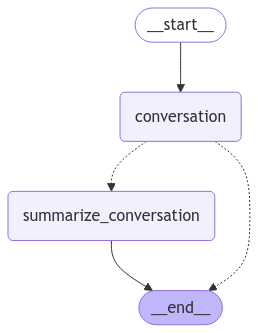

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "1"}}

In [20]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

In [21]:
input_message = HumanMessage(content="hi! I'm bob")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [22]:
input_message = HumanMessage(content="hi! I'm a software engineer")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="I like to code in Javascript, now im learning langchain & langgraph")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm a software engineer
================================== Ai Message ==================================

Hi again Bob! Nice to know that you're a software engineer! What kind of projects have you been working on lately? Are you more into front-end, back-end, or full-stack development?
================================ Remove Message ================================


================================ Remove Message ================================


Here is a summary of our conversation:

* Bob introduced himself and said "hi".
* I responded with a greeting and asked if he needed help or wanted to chat.
* Bob mentioned that he is a software engineer.
* I asked him about his current projects and what type of development he specializes in.
================================ Human Message =================================

I like to code in Javascript, now im learning langchain & langgraph
=================